# Autoregressions

This notebook introduces autoregression modeling using the `AutoReg` model. It also covers aspects of `ar_select_order` assists in selecting models that minimize an information criteria such as the AIC. 
An autoregressive model has dynamics given by 

$$ y_t = \delta + \phi_1 y_{t-1} + \ldots + \phi_p y_{t-p} + \epsilon_t. $$

`AutoReg` also permits models with:

* Deterministic terms (`trend`)
  * `n`: No deterministic term 
  * `c`: Constant (default)
  * `ct`: Constant and time trend
  * `t`: Time trend only
* Seasonal dummies (`seasonal`)
  * `True` includes $s-1$ dummies where $s$ is the period of the time series (e.g., 12 for monthly)
* Custom deterministic terms (`deterministic`)
  * Accepts a `DeterministicProcess`
* Exogenous variables (`exog`)
  * A `DataFrame` or `array` of exogenous variables to include in the model
* Omission of selected lags (`lags`)
  * If `lags` is an iterable of integers, then only these are included in the model.

The complete specification is

$$ y_t = \delta_0 + \delta_1 t + \phi_1 y_{t-1} + \ldots + \phi_p y_{t-p} + \sum_{i=1}^{s-1} \gamma_i d_i + \sum_{j=1}^{m} \kappa_j x_{t,j} + \epsilon_t. $$

where:

* $d_i$ is a seasonal dummy that is 1 if $mod(t, period) = i$. Period 0 is excluded if the model contains a constant (`c` is in `trend`).
* $t$ is a time trend ($1,2,\ldots$) that starts with 1 in the first observation.
* $x_{t,j}$ are exogenous regressors.  **Note** these are time-aligned to the left-hand-side variable when defining a model.
* $\epsilon_t$ is assumed to be a white noise process.

This first cell imports standard packages and sets plots to appear inline.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

This cell sets the plotting style, registers pandas date converters for matplotlib, and sets the default figure size.

In [2]:
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

The first set of examples uses the month-over-month growth rate in U.S. Housing starts that has not been seasonally adjusted. The seasonality is evident by the regular pattern of peaks and troughs. We set the frequency for the time series to "MS" (month-start) to avoid warnings when using `AutoReg`.

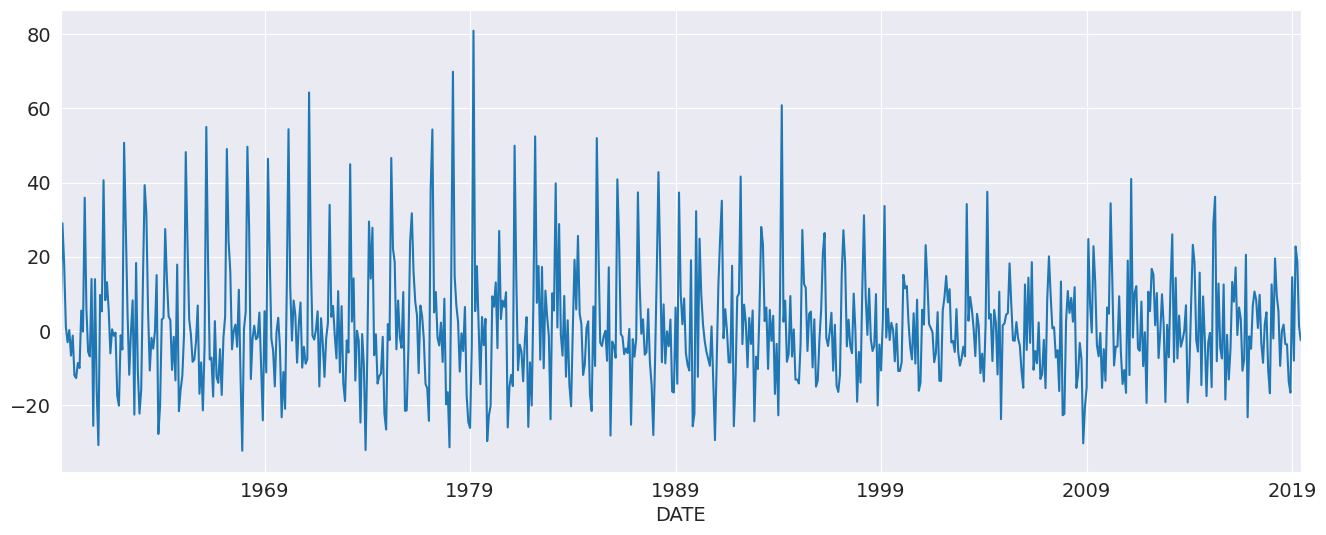

In [3]:
data = pdr.get_data_fred("HOUSTNSA", "1959-01-01", "2019-06-01")
housing = data.HOUSTNSA.pct_change().dropna()
# Scale by 100 to get percentages
housing = 100 * housing.asfreq("MS")
fig, ax = plt.subplots()
ax = housing.plot(ax=ax)

We can start with an AR(3).  While this is not a good model for this data, it demonstrates the basic use of the API.

In [4]:
mod = AutoReg(housing, 3, old_names=False)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:                     AutoReg(3)   Log Likelihood               -2993.442
Method:               Conditional MLE   S.D. of innovations             15.289
Date:                Wed, 02 Nov 2022   AIC                           5996.884
Time:                        17:02:14   BIC                           6019.794
Sample:                    05-01-1959   HQIC                          6005.727
                         - 06-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1228      0.573      1.961      0.050       0.000       2.245
HOUSTNSA.L1     0.1910      0.036      5.235      0.000       0.120       0.263
HOUSTNSA.L2     0.0058      0.037      0.155    

`AutoReg` supports the same covariance estimators as `OLS`.  Below, we use `cov_type="HC0"`, which is White's covariance estimator. While the parameter estimates are the same, all of the quantities that depend on the standard error change.

In [5]:
res = mod.fit(cov_type="HC0")
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:                     AutoReg(3)   Log Likelihood               -2993.442
Method:               Conditional MLE   S.D. of innovations             15.289
Date:                Wed, 02 Nov 2022   AIC                           5996.884
Time:                        17:02:14   BIC                           6019.794
Sample:                    05-01-1959   HQIC                          6005.727
                         - 06-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1228      0.601      1.869      0.062      -0.055       2.300
HOUSTNSA.L1     0.1910      0.035      5.499      0.000       0.123       0.259
HOUSTNSA.L2     0.0058      0.039      0.150    

In [6]:
sel = ar_select_order(housing, 13, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:                    AutoReg(13)   Log Likelihood               -2676.157
Method:               Conditional MLE   S.D. of innovations             10.378
Date:                Wed, 02 Nov 2022   AIC                           5382.314
Time:                        17:02:14   BIC                           5450.835
Sample:                    03-01-1960   HQIC                          5408.781
                         - 06-01-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.3615      0.458      2.970      0.003       0.463       2.260
HOUSTNSA.L1     -0.2900      0.036     -8.161      0.000      -0.360      -0.220
HOUSTNSA.L2     -0.0828      0.031     -2.65

`plot_predict` visualizes forecasts.  Here we produce a large number of forecasts which show the string seasonality captured by the model.

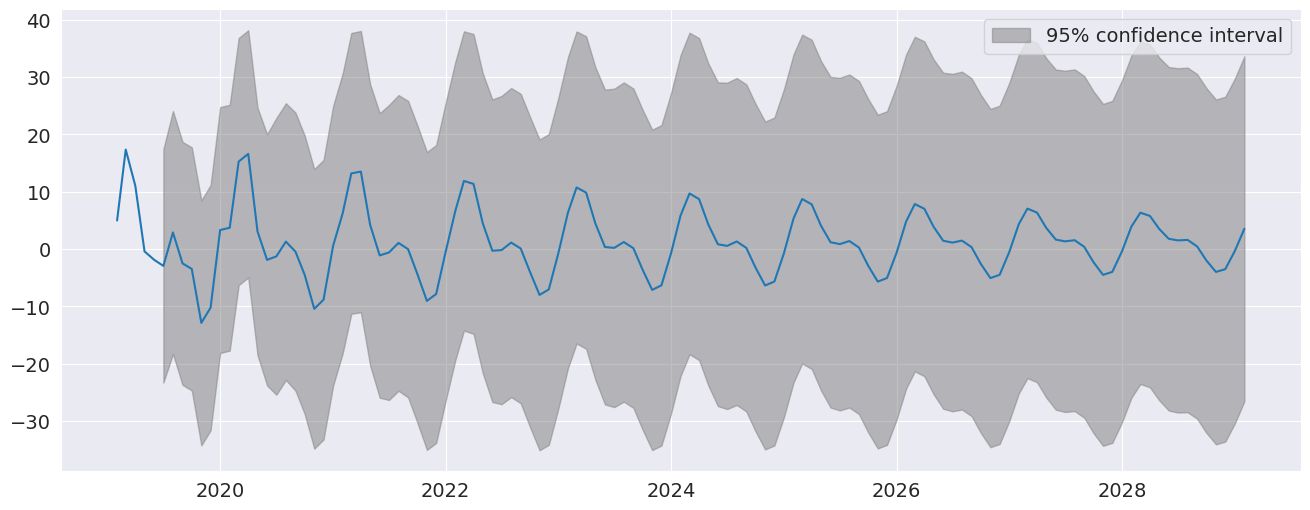

In [7]:
fig = res.plot_predict(720, 840)

`plot_diagnositcs` indicates that the model captures the key features in the data.

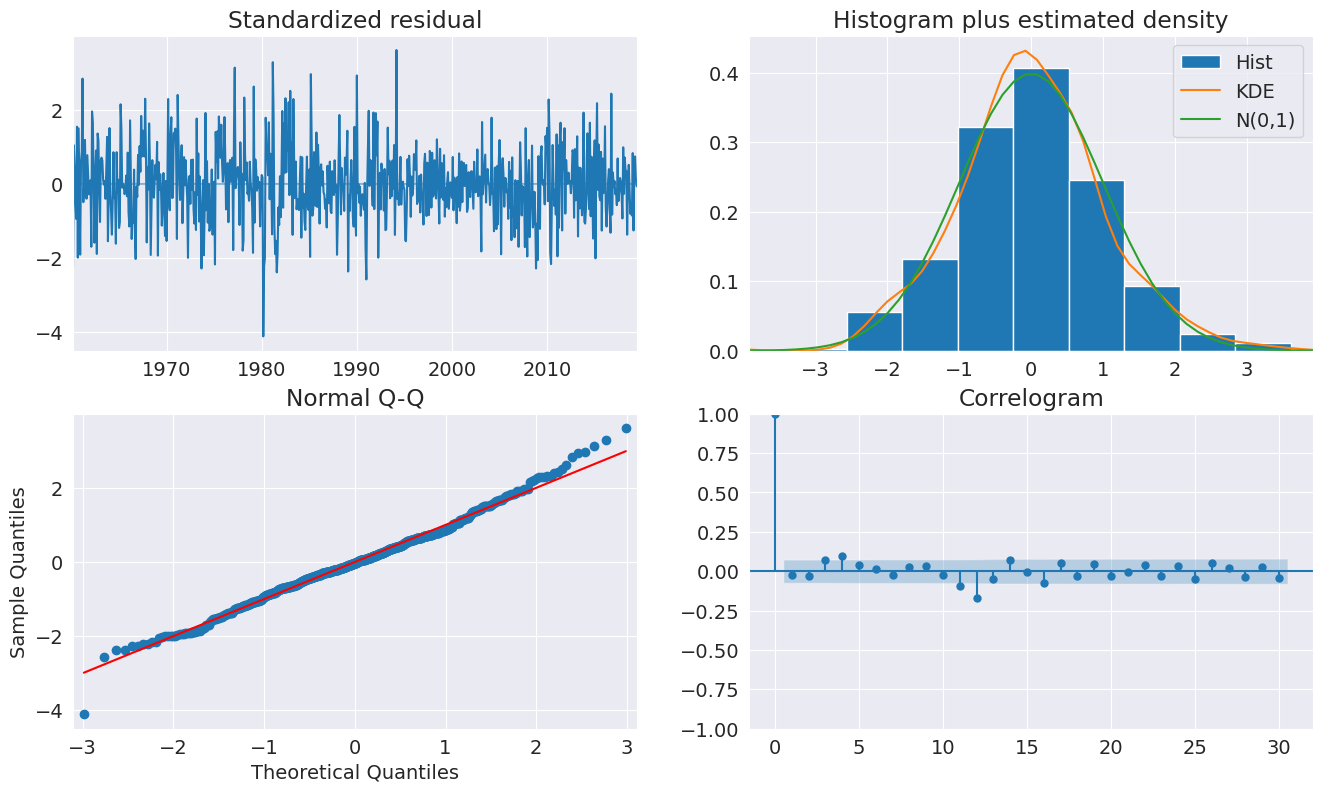

In [8]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

## Seasonal Dummies

`AutoReg` supports seasonal dummies which are an alternative way to model seasonality.  Including the dummies shortens the dynamics to only an AR(2).

In [9]:
sel = ar_select_order(housing, 13, seasonal=True, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:               Seas. AutoReg(2)   Log Likelihood               -2652.556
Method:               Conditional MLE   S.D. of innovations              9.487
Date:                Wed, 02 Nov 2022   AIC                           5335.112
Time:                        17:02:15   BIC                           5403.863
Sample:                    04-01-1959   HQIC                          5361.648
                         - 06-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.2726      1.373      0.927      0.354      -1.418       3.963
s(2,12)        32.6477      1.824     17.901      0.000      29.073      36.222
s(3,12)        23.0685      2.435      9.472    

The seasonal dummies are obvious in the forecasts which has a non-trivial seasonal component in all periods 10 years in to the future.

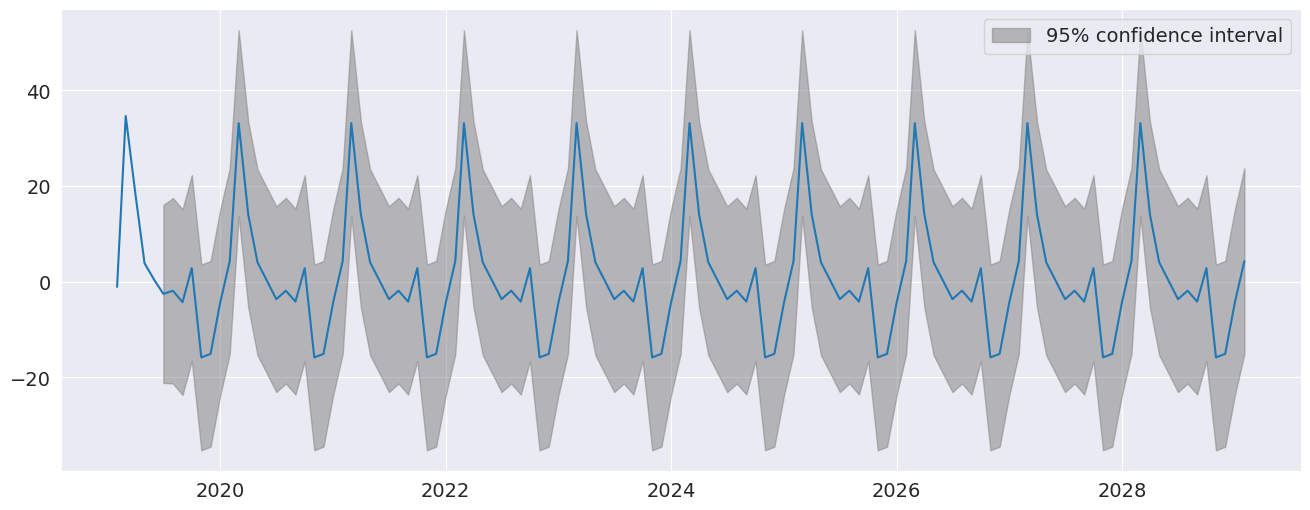

In [10]:
fig = res.plot_predict(720, 840)

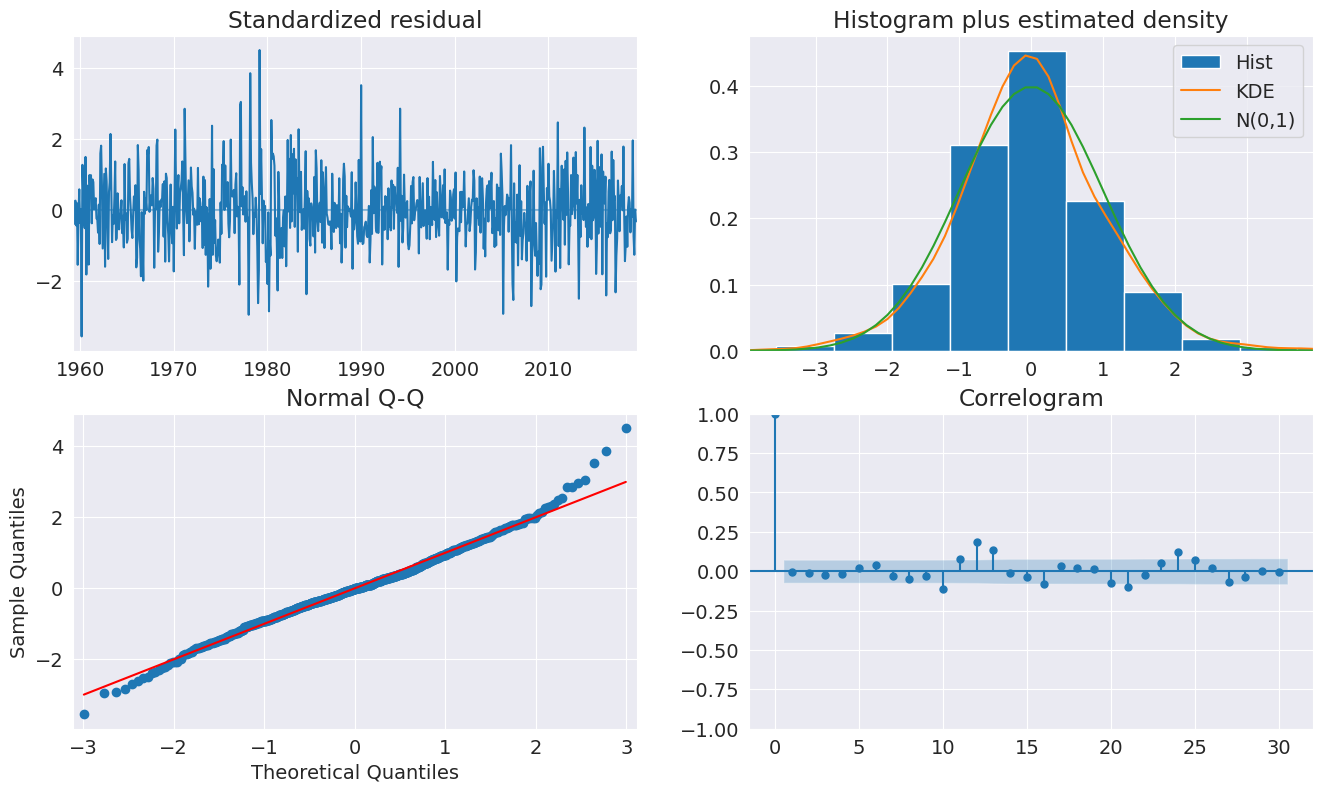

In [11]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(lags=30, fig=fig)

## Seasonal Dynamics

While `AutoReg` does not directly support Seasonal components since it uses OLS to estimate parameters, it is possible to capture seasonal dynamics using an over-parametrized Seasonal AR that does not impose the restrictions in the Seasonal AR. 

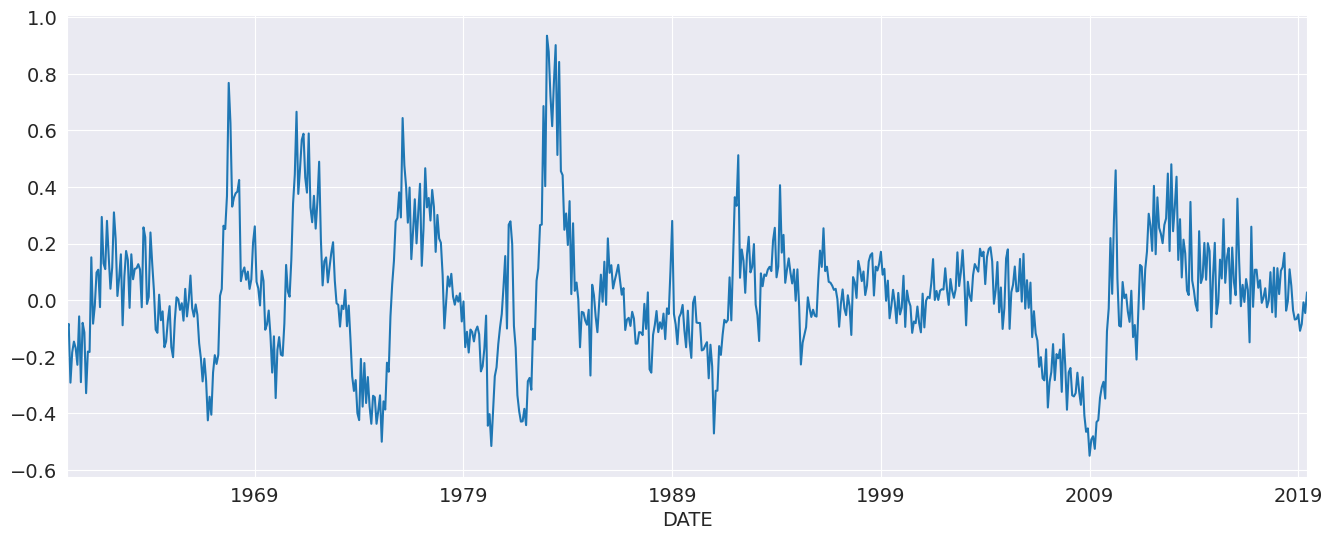

In [12]:
yoy_housing = data.HOUSTNSA.pct_change(12).resample("MS").last().dropna()
_, ax = plt.subplots()
ax = yoy_housing.plot(ax=ax)

We start by selecting a model using the simple method that only chooses the maximum lag.  All lower lags are automatically included. The maximum lag to check is set to 13 since this allows the model to next a Seasonal AR that has both a short-run AR(1) component and a Seasonal AR(1) component, so that

$$ (1-\phi_s L^{12})(1-\phi_1 L)y_t = \epsilon_t $$
which becomes
$$ y_t = \phi_1 y_{t-1} +\phi_s Y_{t-12} - \phi_1\phi_s Y_{t-13} + \epsilon_t $$

when expanded. `AutoReg` does not enforce the structure, but can estimate the nesting model 

$$ y_t = \phi_1 y_{t-1} +\phi_{12} Y_{t-12} - \phi_{13} Y_{t-13} + \epsilon_t. $$

We see that all 13 lags are selected.

In [13]:
sel = ar_select_order(yoy_housing, 13, old_names=False)
sel.ar_lags

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

It seems unlikely that all 13 lags are required.  We can set `glob=True` to search all $2^{13}$ models that include up to 13 lags.

Here we see that the first three are selected, as is the 7th, and finally the 12th and 13th are selected.  This is superficially similar to the structure described above.

After fitting the model, we take a look at the diagnostic plots that indicate that this specification appears to be adequate to capture the dynamics in the data.

In [14]:
sel = ar_select_order(yoy_housing, 13, glob=True, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  714
Model:             Restr. AutoReg(13)   Log Likelihood                 589.177
Method:               Conditional MLE   S.D. of innovations              0.104
Date:                Wed, 02 Nov 2022   AIC                          -1162.353
Time:                        17:02:21   BIC                          -1125.933
Sample:                    02-01-1961   HQIC                         -1148.276
                         - 06-01-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0035      0.004      0.875      0.382      -0.004       0.011
HOUSTNSA.L1      0.5640      0.035     16.167      0.000       0.496       0.632
HOUSTNSA.L2      0.2347      0.038      6.23

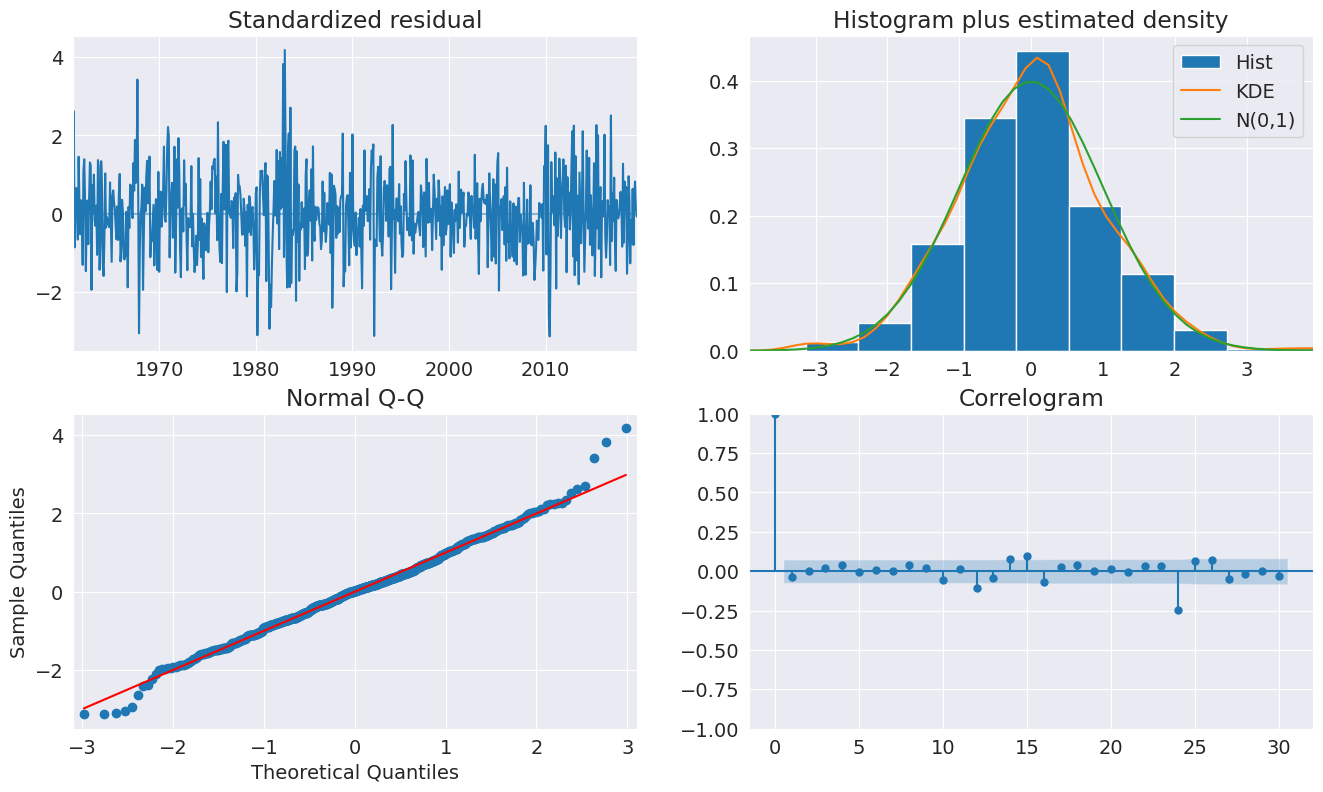

In [15]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

We can also include seasonal dummies.  These are all insignificant since the model is using year-over-year changes.

In [16]:
sel = ar_select_order(yoy_housing, 13, glob=True, seasonal=True, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                               AutoReg Model Results                                
Dep. Variable:                     HOUSTNSA   No. Observations:                  714
Model:             Restr. Seas. AutoReg(13)   Log Likelihood                 590.875
Method:                     Conditional MLE   S.D. of innovations              0.104
Date:                      Wed, 02 Nov 2022   AIC                          -1143.751
Time:                              17:02:36   BIC                          -1057.253
Sample:                          02-01-1961   HQIC                         -1110.317
                               - 06-01-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0167      0.014      1.215      0.224      -0.010       0.044
s(2,12)         -0.0179      0.019     -0.931      0.352      -0.056       0.

## Industrial Production

We will use the industrial production index data to examine forecasting.

<AxesSubplot: xlabel='DATE'>

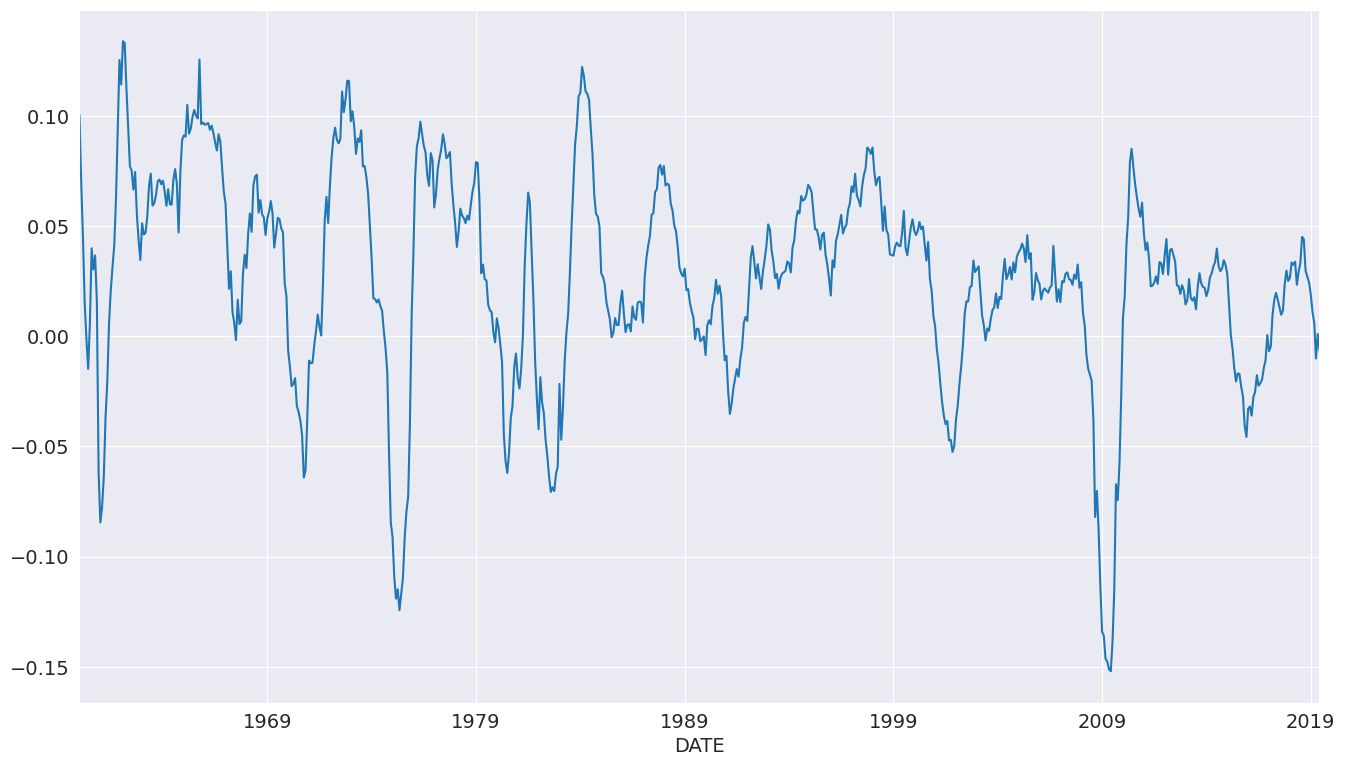

In [17]:
data = pdr.get_data_fred("INDPRO", "1959-01-01", "2019-06-01")
ind_prod = data.INDPRO.pct_change(12).dropna().asfreq("MS")
_, ax = plt.subplots(figsize=(16, 9))
ind_prod.plot(ax=ax)

We will start by selecting a model using up to 12 lags.  An AR(13) minimizes the BIC criteria even though many coefficients are insignificant.

In [18]:
sel = ar_select_order(ind_prod, 13, "bic", old_names=False)
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                 INDPRO   No. Observations:                  714
Model:                    AutoReg(13)   Log Likelihood                2322.270
Method:               Conditional MLE   S.D. of innovations              0.009
Date:                Wed, 02 Nov 2022   AIC                          -4614.540
Time:                        17:02:38   BIC                          -4546.252
Sample:                    02-01-1961   HQIC                         -4588.144
                         - 06-01-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      2.779      0.005       0.000       0.002
INDPRO.L1      1.1582      0.035     33.196      0.000       1.090       1.227
INDPRO.L2     -0.0824      0.053     -1.546      0.1

We can also use a global search which allows longer lags to enter if needed without requiring the shorter lags. Here we see many lags dropped. The model indicates there may be some seasonality in the data. 

In [19]:
sel = ar_select_order(ind_prod, 13, "bic", glob=True, old_names=False)
sel.ar_lags
res_glob = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                 INDPRO   No. Observations:                  714
Model:                    AutoReg(13)   Log Likelihood                2322.270
Method:               Conditional MLE   S.D. of innovations              0.009
Date:                Wed, 02 Nov 2022   AIC                          -4614.540
Time:                        17:02:42   BIC                          -4546.252
Sample:                    02-01-1961   HQIC                         -4588.144
                         - 06-01-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      2.779      0.005       0.000       0.002
INDPRO.L1      1.1582      0.035     33.196      0.000       1.090       1.227
INDPRO.L2     -0.0824      0.053     -1.546      0.1

`plot_predict` can be used to produce forecast plots along with confidence intervals. Here we produce forecasts starting at the last observation and continuing for 18 months.

In [20]:
ind_prod.shape

(714,)

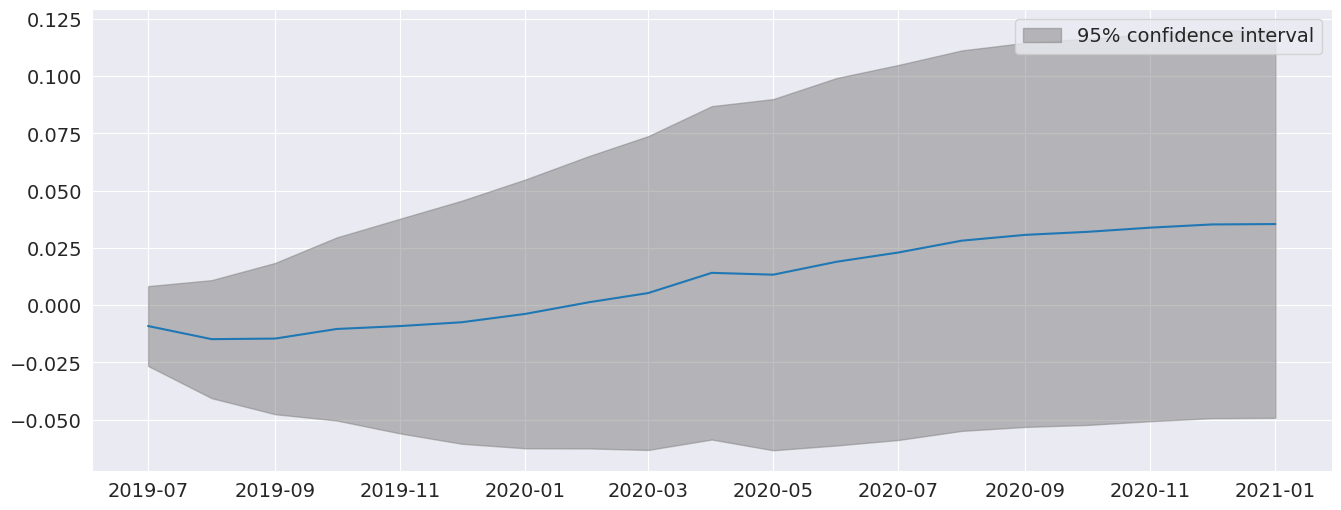

In [21]:
fig = res_glob.plot_predict(start=714, end=732)

The forecasts from the full model and the restricted model are very similar. I also include an AR(5) which has very different dynamics

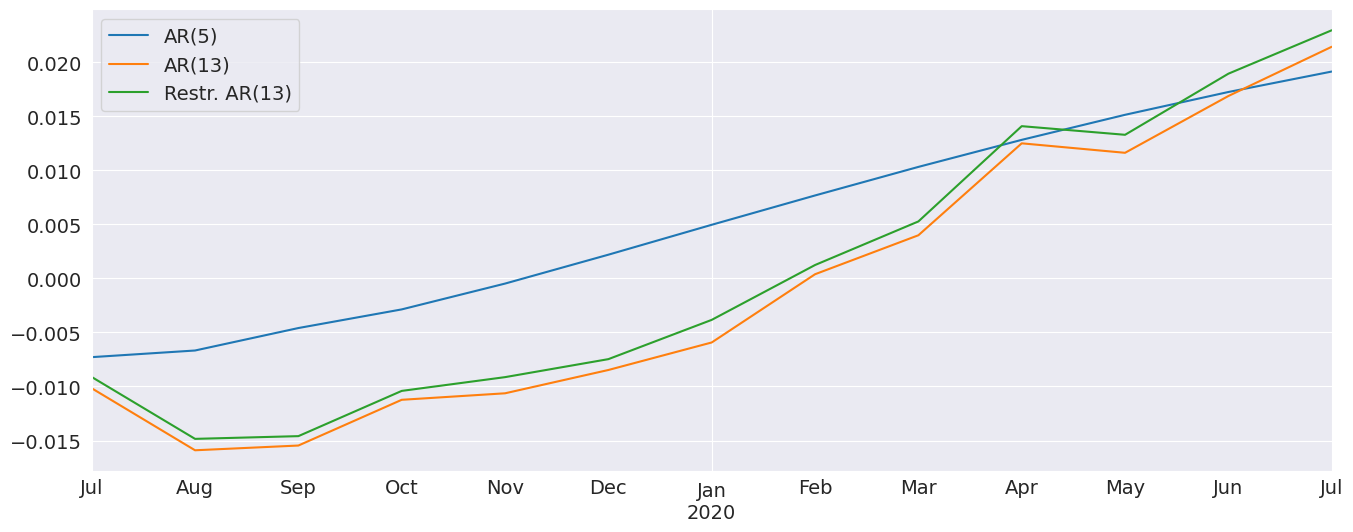

In [22]:
res_ar5 = AutoReg(ind_prod, 5, old_names=False).fit()
predictions = pd.DataFrame(
    {
        "AR(5)": res_ar5.predict(start=714, end=726),
        "AR(13)": res.predict(start=714, end=726),
        "Restr. AR(13)": res_glob.predict(start=714, end=726),
    }
)
_, ax = plt.subplots()
ax = predictions.plot(ax=ax)

The diagnostics indicate the model captures most of the the dynamics in the data. The ACF shows a patters at the seasonal frequency and so a more complete seasonal model (`SARIMAX`) may be needed.

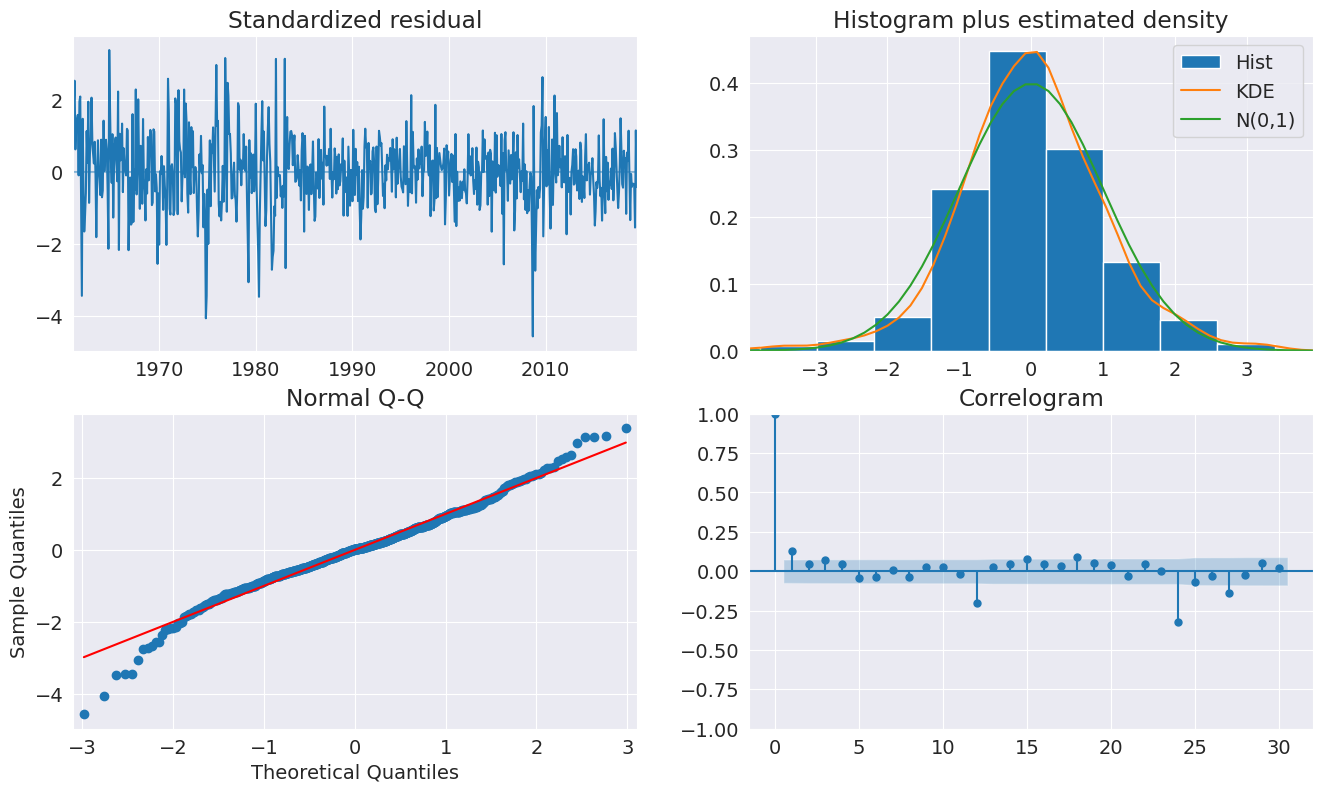

In [23]:
fig = plt.figure(figsize=(16, 9))
fig = res_glob.plot_diagnostics(fig=fig, lags=30)

# Forecasting

Forecasts are produced using the `predict` method from a results instance. The default produces static forecasts which are one-step forecasts. Producing multi-step forecasts requires using `dynamic=True`.  

In this next cell, we produce 12-step-heard forecasts for the final 24 periods in the sample.  This requires a loop.

**Note**: These are technically in-sample since the data we are forecasting was used to estimate parameters. Producing OOS forecasts requires two models.  The first must exclude the OOS period.  The second uses the `predict` method from the full-sample model with the parameters from the shorter sample model that excluded the OOS period.

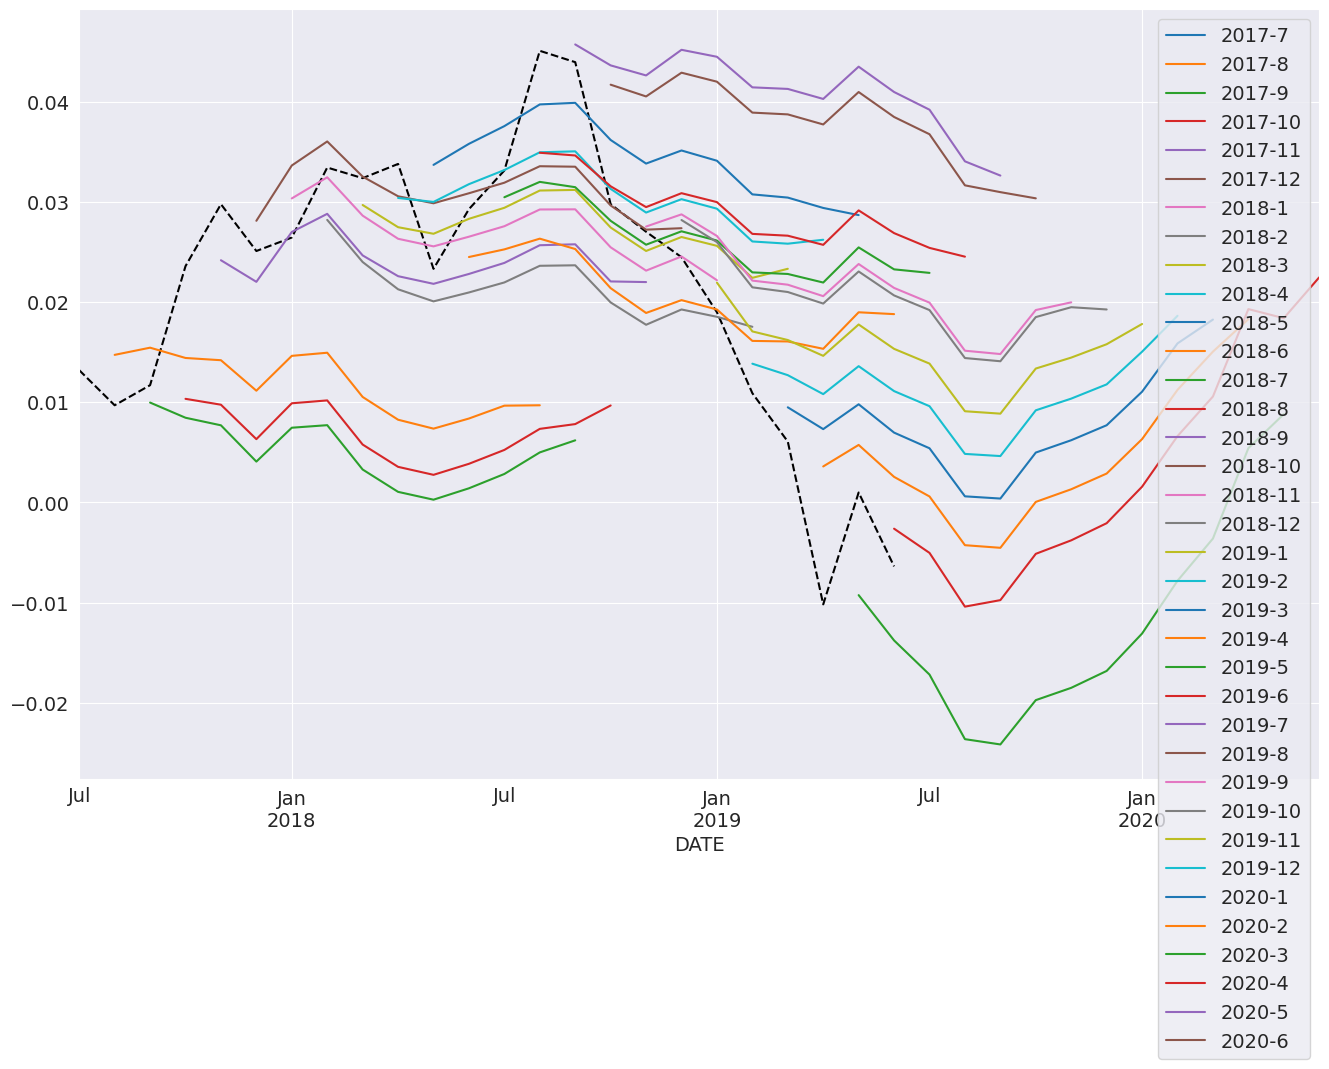

In [24]:
import numpy as np

start = ind_prod.index[-24]
forecast_index = pd.date_range(start, freq=ind_prod.index.freq, periods=36)
cols = ["-".join(str(val) for val in (idx.year, idx.month)) for idx in forecast_index]
forecasts = pd.DataFrame(index=forecast_index, columns=cols)
for i in range(1, 24):
    fcast = res_glob.predict(
        start=forecast_index[i], end=forecast_index[i + 12], dynamic=True
    )
    forecasts.loc[fcast.index, cols[i]] = fcast
_, ax = plt.subplots(figsize=(16, 10))
ind_prod.iloc[-24:].plot(ax=ax, color="black", linestyle="--")
ax = forecasts.plot(ax=ax)

## Comparing to SARIMAX

`SARIMAX` is an implementation of a Seasonal Autoregressive Integrated Moving Average with eXogenous regressors model.  It supports:

* Specification of seasonal and nonseasonal AR and MA components
* Inclusion of Exogenous variables
* Full maximum-likelihood estimation using the Kalman Filter

This model is more feature rich than `AutoReg`. Unlike `SARIMAX`, `AutoReg` estimates parameters using OLS.  This is faster and the problem is globally convex, and so there are no issues with local minima. The closed-form estimator and its performance are the key advantages of `AutoReg` over `SARIMAX` when comparing AR(P) models.  `AutoReg` also support seasonal dummies, which can be used with `SARIMAX` if the user includes them as exogenous regressors. 

In [25]:
from statsmodels.tsa.api import SARIMAX

sarimax_mod = SARIMAX(ind_prod, order=((1, 5, 12, 13), 0, 0), trend="c")
sarimax_res = sarimax_mod.fit()
print(sarimax_res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.22003D+00    |proj g|=  1.79176D+01


 This problem is unconstrained.



At iterate    5    f= -3.22590D+00    |proj g|=  1.52234D-01



At iterate   10    f= -3.22626D+00    |proj g|=  1.46462D+00

At iterate   15    f= -3.22650D+00    |proj g|=  7.26461D-01



At iterate   20    f= -3.22710D+00    |proj g|=  2.43602D-01

At iterate   25    f= -3.22712D+00    |proj g|=  2.14705D-01



At iterate   30    f= -3.22748D+00    |proj g|=  2.06711D+00



At iterate   35    f= -3.22778D+00    |proj g|=  1.55221D-01



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     56      1     0     0   2.540D-03  -3.228D+00
  F =  -3.2277841127448630     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                     
Dep. Variable:                            INDPRO   No. Observations:                  714
Model:             SARIMAX([1, 5, 12, 13], 0, 0)   Log Likelihood                2304.638
Date:                           Wed, 02 Nov 2022   AIC                          -4597.276
Time:                                   17:02:48   BIC         


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [26]:
sarimax_params = sarimax_res.params.iloc[:-1].copy()
sarimax_params.index = res_glob.params.index
params = pd.concat([res_glob.params, sarimax_params], axis=1, sort=False)
params.columns = ["AutoReg", "SARIMAX"]
params

,AutoReg,SARIMAX
const,0.001229,0.001077
INDPRO.L1,1.088978,1.080341
INDPRO.L5,-0.105816,-0.084837
INDPRO.L12,-0.388509,-0.443111
INDPRO.L13,0.362515,0.407657


## Custom Deterministic Processes

The `deterministic` parameter allows a custom `DeterministicProcess` to be used. This allows for more complex deterministic terms to be constructed, for example one that includes seasonal components with two periods, or, as the next example shows, one that uses a Fourier series rather than seasonal dummies.

In [27]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(housing.index, constant=True, period=12, fourier=2)
mod = AutoReg(housing, 2, trend="n", seasonal=False, deterministic=dp)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:                     AutoReg(2)   Log Likelihood               -2716.505
Method:               Conditional MLE   S.D. of innovations             10.364
Date:                Wed, 02 Nov 2022   AIC                           5449.010
Time:                        17:02:48   BIC                           5485.677
Sample:                    04-01-1959   HQIC                          5463.163
                         - 06-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.7550      0.391      4.485      0.000       0.988       2.522
sin(1,12)      16.7443      0.860     19.478      0.000      15.059      18.429
cos(1,12)       4.9409      0.588      8.409    

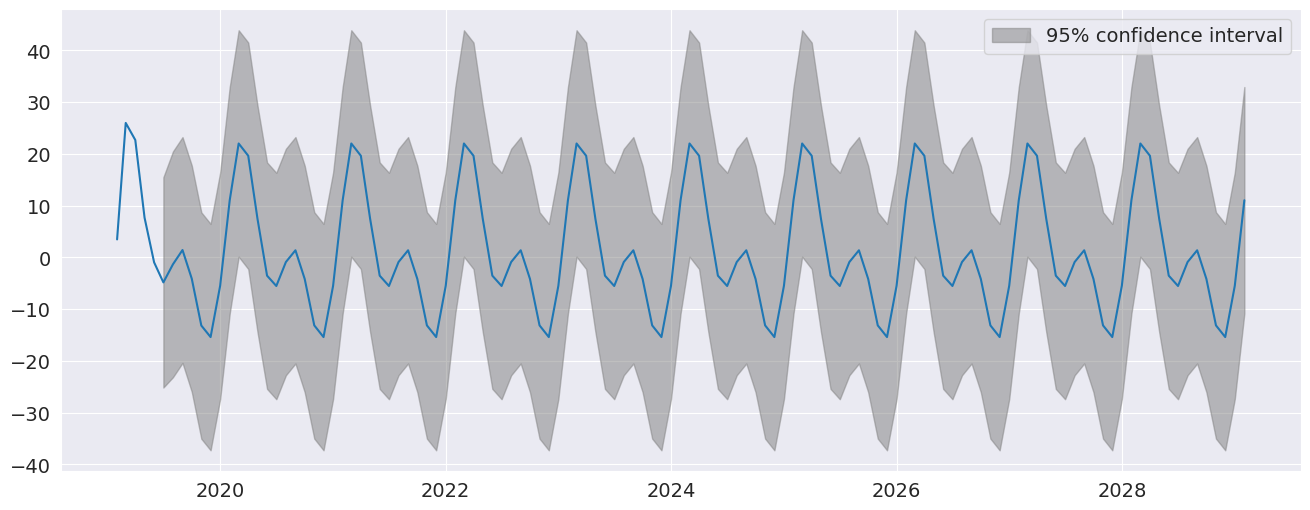

In [28]:
fig = res.plot_predict(720, 840)